<a href="https://colab.research.google.com/github/MarioSigal/Aprendizaje-Automatico-I-y-II/blob/main/TP_2_Aprendizaje_Automatico_0_5_con_matrices.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Imports


In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertModel
from typing import List, Dict, Any
import numpy as np
import pandas as pd
from google.colab import drive

#DATA FRAME


In [9]:
#Cargar drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
!ls /content/drive/MyDrive/

 05_y_pred_held_out_9352.csv
 -1009439638.gdoc
 -1017745828.gdoc
 1508236754.gdoc
 16042f82421169b6ce50aa4406b0392b.gif
 16_nov_2021_RESUELTO.pdf
 1cbb1ad1-b8ee-45a3-ab1f-774053b3dbe7.jpg
'1er parcial Química 2021.gdoc'
'2023-10-20T14 47 38+00 00_0mgfi.gsheet'
 2_46.mp3
 25_nov_2021_Turno1_RESUELTO.pdf
 25_nov_2021_Turno2_RESUELTO.pdf
 25_nov_2021_Turno3_RESUELTO.pdf
'2da y 3ra Ley de Newton.gdoc'
'2 Parcial Química.gdoc'
 4AFCD65A-46F0-45CA-96F5-7E2EF2E6AB9D.jpeg
 4fe7a276-6bd0-49a0-97e1-c83554cf43ac.mp4
'5to nat séptima clase virtual.gdoc'
'5to naturales- 3era clase virtual- Tobias LLop.docx'
'8 ESCALONES PREGUNTAS.gsheet'
'Actividad 1.pdf'
'Actividad 1-Tobias Llop.gdoc'
'Actividad 2 - Punto 4.gdoc'
'ACTIVIDAD 4: Guía de análisis para el Capitulo 1 de Adolfo Carpio. (28 may. 2021 10:41)'
'ACTIVIDAD 6: Guía de análisis de Modernidad y Posmodernidad. (25 oct. 2021 23:29)'
'ACTIVIDAD 6: Guía de análisis de Modernidad y Posmodernidad. (25 oct. 2021 23:30)'
'ACTIVIDADES CLASE 6.g

In [11]:
df = pd.read_csv("/content/drive/MyDrive/colab/dataset_datos_total3.csv")

In [12]:
# Agrupar tokens por párrafo
df_por_parrafos = df.groupby("instancia_id").agg({
    "token_id":list,
    "token": list,
    "punt_inicial": list,
    "punt_final": list,
    "capitalización": list
}).reset_index()


In [13]:
for index, row in df.iterrows(): # Correctly iterate over DataFrame rows
  bi = 0
  bf = 0
  bc = 0
  if row["punt_inicial"] is None:
    bi += 1
  if row["punt_final"] is None:
    bf += 1
  if row["capitalización"] is None:
    bc += 1

print(bi,bf,bc)

0 0 0


In [14]:
import math

def count_nans_in_df_lists(dataframe, columns_to_check=None):
    """
    Cuenta los valores NaN en las listas contenidas en las columnas especificadas de un DataFrame.

    Args:
        dataframe (pd.DataFrame): El DataFrame a revisar.
        columns_to_check (list, optional): Lista de nombres de columnas a revisar.
                                          Si es None, revisa 'punt_inicial', 'punt_final', 'capitalización'.

    Returns:
        dict: Un diccionario con el conteo de NaN por columna.
    """
    if columns_to_check is None:
        columns_to_check = ['punt_inicial', 'punt_final', 'capitalización']

    nan_counts = {col: 0 for col in columns_to_check}
    total_nans_found = 0

    for col in columns_to_check:
        if col not in dataframe.columns:
            print(f"Advertencia: La columna '{col}' no se encuentra en el DataFrame.")
            continue

        for index, row_list in dataframe[col].items():
            if isinstance(row_list, list):
                for item in row_list:
                    if isinstance(item, float) and math.isnan(item):
                        nan_counts[col] += 1
                        total_nans_found += 1
            elif isinstance(row_list, float) and math.isnan(row_list): # Handle cases where the cell itself is NaN, not a list
                nan_counts[col] += 1
                total_nans_found += 1

    print(f"Resumen de NaN encontrados por columna:")
    for col, count in nan_counts.items():
        print(f"  - '{col}': {count} NaN(s)")
    print(f"Total de NaN encontrados en todas las columnas: {total_nans_found}")

    return nan_counts

In [15]:
import math

def filter_rows_with_nans_in_lists(df, columns):
    """
    Filtra las filas de un DataFrame donde alguna de las listas en las columnas especificadas
    contenga valores NaN.
    """
    initial_rows = len(df)
    print(f"Filas iniciales en el DataFrame: {initial_rows}")

    # Crear una máscara booleana para las filas a mantener (True si NO hay NaN)
    mask = pd.Series([True] * len(df), index=df.index)

    for col in columns:
        # Para cada fila, comprueba si alguna lista contiene NaN
        # Aplicamos `.all()` para asegurarnos de que solo se considere False si hay al menos un NaN
        col_mask = df[col].apply(lambda lst: not any(isinstance(x, float) and math.isnan(x) for x in lst) if isinstance(lst, list) else (not (isinstance(lst, float) and math.isnan(lst))))
        mask = mask & col_mask

    df_filtered = df[mask].reset_index(drop=True)
    removed_rows = initial_rows - len(df_filtered)
    print(f"Filas con NaN eliminadas: {removed_rows}")
    print(f"Filas restantes en el DataFrame: {len(df_filtered)}")
    return df_filtered

# Columnas donde buscar NaN en las listas
columns_to_check = ['punt_inicial', 'punt_final', 'capitalización']

# Filtrar df_por_parrafos
df_por_parrafos = filter_rows_with_nans_in_lists(df_por_parrafos, columns_to_check)

# Opcional: Volver a verificar los NaN después de filtrar
print("\nVerificando NaN después de filtrar:")
count_nans_in_df_lists(df_por_parrafos)

Filas iniciales en el DataFrame: 243621
Filas con NaN eliminadas: 0
Filas restantes en el DataFrame: 243621

Verificando NaN después de filtrar:
Resumen de NaN encontrados por columna:
  - 'punt_inicial': 0 NaN(s)
  - 'punt_final': 0 NaN(s)
  - 'capitalización': 0 NaN(s)
Total de NaN encontrados en todas las columnas: 0


{'punt_inicial': 0, 'punt_final': 0, 'capitalización': 0}

In [16]:
print("Contando NaN en df_por_parrafos...")
count_nans_in_df_lists(df_por_parrafos)

Contando NaN en df_por_parrafos...
Resumen de NaN encontrados por columna:
  - 'punt_inicial': 0 NaN(s)
  - 'punt_final': 0 NaN(s)
  - 'capitalización': 0 NaN(s)
Total de NaN encontrados en todas las columnas: 0


{'punt_inicial': 0, 'punt_final': 0, 'capitalización': 0}

In [17]:
print(df_por_parrafos["token"][1])
print(df.shape)

['¡', 'pero', 'he', '##idi', 'las', 'cosas', 'no', 'son', 'tan', 'simples', '!']
(6855019, 6)


##TOKENIZER & BERT EMBEDDINGS

In [18]:
"""##TOKENIZER & BERT EMBEDDINGS"""

tokenizer = BertTokenizer.from_pretrained("bert-base-multilingual-cased")
model_bert = BertModel.from_pretrained("bert-base-multilingual-cased")
model_bert.eval()


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(119547, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=Fals

In [19]:
# Congelar parámetros de BERT para ahorrar memoria
for param in model_bert.parameters():
    param.requires_grad = False

##CREAR CLASE DATASET PARA PYTORCH

In [20]:
from torch.utils.data import Dataset

class DynamicEmbeddingDataset(Dataset):
    """Dataset de pytorch que calcula embeddings dinámicamente"""
    def __init__(self, df, tokenizer, bert_model):
        self.df = df
        self.tokenizer = tokenizer
        self.bert_model = bert_model
        self.embedding_matrix = bert_model.embeddings.word_embeddings.weight
        self.embedding_matrix.requires_grad = False

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        token_id_list = row["token_id"]

        # Calcular embeddings dinámicamente
        token_embeddings = []
        for token_id in token_id_list:
            if token_id is None or token_id == self.tokenizer.unk_token_id:
                token_id = self.tokenizer.unk_token_id
            emb = self.embedding_matrix[token_id].detach()
            token_embeddings.append(emb)

        # Convertir a tensor
        if token_embeddings:
            embeddings = torch.stack(token_embeddings)
        else:
            embeddings = torch.empty(0, self.embedding_matrix.shape[1])

        # Preparar labels
        labels = {
            "punt_inicial": torch.tensor(row["punt_inicial"], dtype=torch.long),
            "punt_final": torch.tensor(row["punt_final"], dtype=torch.long),
            "capitalización": torch.tensor(row["capitalización"], dtype=torch.long)
        }

        return embeddings, labels

##PADDING

In [21]:
from torch.nn.utils.rnn import pad_sequence

def collate_fn(batch):
    """
    batch: lista de tuplas (embeddings, labels)
    """
    embeddings_list, labels_list = zip(*batch)

    # Pad embeddings (seq_len, embedding_dim) -> (batch_size, max_seq_len, embedding_dim)
    embeddings_padded = pad_sequence(embeddings_list, batch_first=True, padding_value=0.0)

    # Pad labels
    punt_inicial = pad_sequence([l["punt_inicial"] for l in labels_list], batch_first=True, padding_value=-100).long()
    punt_final = pad_sequence([l["punt_final"] for l in labels_list], batch_first=True, padding_value=-100).long()
    capitalizacion = pad_sequence([l["capitalización"] for l in labels_list], batch_first=True, padding_value=-100).long()

    return embeddings_padded, {
        "punt_inicial": punt_inicial,
        "punt_final": punt_final,
        "capitalizacion": capitalizacion
    }

## DATA LOADER

In [22]:
#TEST
#print(int(len(df_por_parrafos)*0.9)) # da 122454, despues agarrar tail de eso
df_por_parrafos_test = df_por_parrafos

from torch.utils.data import DataLoader

# Usar el nuevo dataset con embeddings dinámicos
dataset = DynamicEmbeddingDataset(df_por_parrafos_test, tokenizer, model_bert)
dataloader = DataLoader(dataset, batch_size=8, shuffle=True, collate_fn=collate_fn)


##RNN Unidireccional

In [2]:
class RNN_Unidireccional(nn.Module):
    def __init__(self, embedding_dim = 768, hidden_dim1 = 128, hidden_dim2 = 32, num_layers= 2, dropout= 0.4):
        super(RNN_Unidireccional, self).__init__()

        # LSTM
        self.lstm = nn.LSTM(
            input_size=embedding_dim,
            hidden_size=hidden_dim1,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout,
            bidirectional=False  # Unidireccional
            )

        # Dropout
        self.dropout = nn.Dropout(dropout)

        # Salidas
        self.punt_inicial_ff = nn.Sequential(
            nn.Linear(hidden_dim1, hidden_dim2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim2, 2)
            )
        self.punt_final_ff = nn.Sequential(
            nn.Linear(hidden_dim1, hidden_dim2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim2, 4)
            )
        self.capital_ff = nn.Sequential(
            nn.Linear(hidden_dim1, hidden_dim2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim2, 4)
            )

    def forward(self, embeddings):
        """
        embeddings: tensor de forma (batch_size, seq_len, embedding_dim)
        """
        # Pasamos los embeddings por la lstm
        outputs, _ = self.lstm(embeddings)

        # Les hacemos dropout a los outputs
        outputs = self.dropout(outputs)

        # Pasamos los outputs de la lstm por las salidas
        punt_inicial_logits = self.punt_inicial_ff(outputs)
        punt_final_logits = self.punt_final_ff(outputs)
        capital_logits = self.capital_ff(outputs)

        return {
            "puntuación inicial": punt_inicial_logits,
            "puntuación final": punt_final_logits,
            "capitalización": capital_logits,
        }


In [5]:
!pip install torchview

from torchview import draw_graph

model = RNN_Unidireccional(embedding_dim=768, hidden_dim1=128, hidden_dim2=32, num_layers=2, dropout=0.4)

model_graph = draw_graph(
    model,
    input_size=(1, 50, 768),  # (batch_size, seq_len, embedding_dim)
    expand_nested= False,
    graph_name='RNN_Unidireccional'
)

model_graph.visual_graph.render("rnn_arquitectura", format="png")

print("✓ Imagen guardada como 'rnn_arquitectura.png'")

✓ Imagen guardada como 'rnn_arquitectura.png'


## RNN Bidireccional


In [6]:
class RNN_Bidireccional(nn.Module):
    def __init__(self, embedding_dim = 768, hidden_dim1 = 64, hidden_dim2 = 32, num_layers= 2, dropout= 0.4): #reducimos hidden_dim1 para equiparar con la red unidireccional( 64*2 = 128)
        super(RNN_Bidireccional, self).__init__()

        # LSTM
        self.lstm = nn.LSTM(
            input_size=embedding_dim,
            hidden_size=hidden_dim1,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout,
            bidirectional=True  # Bidireccional
            )

        lstm_output_dim = hidden_dim1 * 2 #128 igual que en la Unidireccinal

        # Dropout
        self.dropout = nn.Dropout(dropout)

        # Salidas
        self.punt_inicial_ff = nn.Sequential(
            nn.Linear(lstm_output_dim, hidden_dim2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim2, 2)
            )
        self.punt_final_ff = nn.Sequential(
            nn.Linear(lstm_output_dim, hidden_dim2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim2, 4)
            )
        self.capital_ff = nn.Sequential(
            nn.Linear(lstm_output_dim, hidden_dim2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim2, 4)
            )

    def forward(self, embeddings):
        """
        embeddings: tensor de forma (batch_size, seq_len, embedding_dim)
        """
        # Pasamos los embeddings por la lstm
        outputs, _ = self.lstm(embeddings)

        # Les hacemos dropout a los outputs
        outputs = self.dropout(outputs)

        # Pasamos los outputs de la lstm por las salidas
        punt_inicial_logits = self.punt_inicial_ff(outputs)
        punt_final_logits = self.punt_final_ff(outputs)
        capital_logits = self.capital_ff(outputs)

        return {
            "puntuación inicial": punt_inicial_logits,
            "puntuación final": punt_final_logits,
            "capitalización": capital_logits,
        }

In [7]:
# Crear el modelo
model = RNN_Bidireccional(embedding_dim=768, hidden_dim1=64, hidden_dim2=32, num_layers=2, dropout=0.4)

# Generar visualización
model_graph = draw_graph(
    model,
    input_size=(1, 50, 768),  # (batch_size, seq_len, embedding_dim)
    expand_nested=True,
    graph_name='RNN_Bidireccional'
)

# Guardar como PNG
model_graph.visual_graph.render("rnn_bidireccional", format="png")

print("✓ Imagen guardada como 'rnn_bidireccional.png'")

✓ Imagen guardada como 'rnn_bidireccional.png'


##ENTRENAR MODELO Unidireccional


In [23]:
from sklearn.model_selection import train_test_split
import torch.nn.utils as nn_utils

# Dividir en train/validation/test
train_df, temp = train_test_split(df_por_parrafos, test_size=0.2, shuffle=True, random_state=42)

val_df, test_df = train_test_split(temp, test_size=0.5, shuffle=True, random_state=42)

train_dataset = DynamicEmbeddingDataset(train_df.reset_index(drop=True), tokenizer, model_bert)
val_dataset = DynamicEmbeddingDataset(val_df.reset_index(drop=True), tokenizer, model_bert)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, collate_fn=collate_fn)

In [ ]:
from sklearn.model_selection import train_test_split
import torch.nn.utils as nn_utils

model = RNN_Unidireccional(embedding_dim=768, hidden_dim1=128, hidden_dim2=32,  num_layers=2, dropout=0.4)
device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)

# Mover BERT a la misma device
model_bert = model_bert.to(device)

# Optimizador con weight decay (regularización L2)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)

# Learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.2, patience=3
)

# Pesos diferentes para cada tarea (opcional, ajustar según importancia)
criterion = torch.nn.CrossEntropyLoss(ignore_index=-100, label_smoothing=0.1)

# Gradient clipping
max_grad_norm = 1.0

num_epochs = 30
best_val_loss = float('inf')
patience_counter = 0
early_stop_patience = 30

for epoch in range(num_epochs):
    # ENTRENAMIENTO
    model.train()
    total_train_loss = 0
    total_loss_inicial = 0
    total_loss_final = 0
    total_loss_cap = 0

    for embeddings, labels in train_loader:
        embeddings = embeddings.to(device)
        labels = {k: v.to(device) for k, v in labels.items()}

        optimizer.zero_grad()
        outputs = model(embeddings)

        loss_inicial = 2*criterion(outputs["puntuación inicial"].permute(0,2,1), labels["punt_inicial"]) #testeando, le pongo 100* a los inicial porque es muy chica
        loss_final = criterion(outputs["puntuación final"].permute(0,2,1), labels["punt_final"])
        loss_cap = criterion(outputs["capitalización"].permute(0,2,1), labels["capitalizacion"])

        # Pérdida total
        loss = loss_inicial + loss_final + loss_cap

        loss.backward()

        # Gradient clipping para evitar gradientes explosivos
        nn_utils.clip_grad_norm_(model.parameters(), max_grad_norm)

        optimizer.step()

        total_train_loss += loss.item()
        total_loss_inicial += loss_inicial.item()
        total_loss_final += loss_final.item()
        total_loss_cap += loss_cap.item()

    avg_train_loss = total_train_loss / len(train_loader)

    # VALIDACIÓN
    model.eval()
    total_val_loss = 0
    val_loss_inicial = 0
    val_loss_final = 0
    val_loss_cap = 0

    with torch.no_grad():
        for embeddings, labels in val_loader:
            embeddings = embeddings.to(device)
            labels = {k: v.to(device) for k, v in labels.items()}

            outputs = model(embeddings)

            loss_inicial = 2*criterion(outputs["puntuación inicial"].permute(0,2,1), labels["punt_inicial"])  #testeando, le pongo 100* a los inicial porque es muy chica

            loss_final = criterion(outputs["puntuación final"].permute(0,2,1), labels["punt_final"])

            loss_cap = criterion(outputs["capitalización"].permute(0,2,1), labels["capitalizacion"])

            loss = loss_inicial + loss_final + loss_cap

            total_val_loss += loss.item()
            val_loss_inicial += loss_inicial.item()
            val_loss_final += loss_final.item()
            val_loss_cap += loss_cap.item()

    avg_val_loss = total_val_loss / len(val_loader)

    # Actualizar learning rate
    scheduler.step(avg_val_loss)

    # Imprimir métricas detalladas
    print(f"Época {epoch+1}/{num_epochs}")
    print(f"  Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")
    print(f"  Train - Inicial: {total_loss_inicial/len(train_loader):.4f}, Final: {total_loss_final/len(train_loader):.4f}, Cap: {total_loss_cap/len(train_loader):.4f}")
    print(f"  Val   - Inicial: {val_loss_inicial/len(val_loader):.4f}, Final: {val_loss_final/len(val_loader):.4f}, Cap: {val_loss_cap/len(val_loader):.4f}")
    print(f"  LR: {optimizer.param_groups[0]['lr']:.6f}")


    # Guardar cada epoca
    ruta_epoca = f"/content/drive/MyDrive/colab/modelosU/modelo_epoca_{epoch+1}.pt"
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'val_loss': avg_val_loss,
        }, ruta_epoca)


    # Guardar mejor modelo
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
        ruta_mejor_modelo = "/content/drive/MyDrive/colab/modelosU/mejor_modelo.pt"
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_loss': avg_val_loss,
        }, ruta_mejor_modelo)
        print(f"  ✓ Mejor modelo actualizado (Val Loss: {avg_val_loss:.4f})")
    else:
        patience_counter += 1
        print(f"  Sin mejora ({patience_counter}/{early_stop_patience})")

    # Early stopping
    if patience_counter >= early_stop_patience:
        print(f"\nEarly stopping en época {epoch+1}")
        break

    print("-" * 60)


print(f"\nEntrenamiento completado!")
print(f"Mejor modelo guardado en: {ruta_mejor_modelo}")
print(f"Mejor Val Loss: {best_val_loss:.4f}")


###EVALUACION UNIDIRECCIONAL

In [26]:
from sklearn.metrics import f1_score

model = RNN_Unidireccional(embedding_dim=768, hidden_dim1=128, hidden_dim2=32,  num_layers=2, dropout=0.4)
device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)

# ---------------------------------------
# EVALUACIÓN SOBRE EL TEST SET
# ---------------------------------------

test_dataset = DynamicEmbeddingDataset(test_df.reset_index(drop=True), tokenizer, model_bert)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, collate_fn=collate_fn)

# Cargar el mejor modelo
checkpoint = torch.load("/content/drive/MyDrive/colab/modelosU/mejor_modelo.pt") #modelosU para unidireccional
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

print("\n=== Evaluando en TEST SET con mejor modelo Unidireccional ===\n")

criterion = torch.nn.CrossEntropyLoss(ignore_index=-100)

total_test_loss = 0
loss_init = 0
loss_final = 0
loss_cap = 0

# Para F1
all_true_init  = []
all_pred_init  = []

all_true_final = []
all_pred_final = []

all_true_cap   = []
all_pred_cap   = []

correct_init = 0
correct_final = 0
correct_cap = 0

total_tokens = 0

with torch.no_grad():
    for embeddings, labels in test_loader:
        embeddings = embeddings.to(device)
        labels = {k: v.to(device) for k, v in labels.items()}

        outputs = model(embeddings)

        # Loss
        l_i = 2*criterion(outputs["puntuación inicial"].permute(0,2,1), labels["punt_inicial"]) # 2* para equipararla con las otras
        l_f = criterion(outputs["puntuación final"].permute(0,2,1), labels["punt_final"])
        l_c = criterion(outputs["capitalización"].permute(0,2,1), labels["capitalizacion"])

        loss = l_i + l_f + l_c

        total_test_loss += loss.item()
        loss_init += l_i.item()
        loss_final += l_f.item()
        loss_cap += l_c.item()

        # Predicciones (batch, seq)
        pred_init = outputs["puntuación inicial"].argmax(dim=-1)
        pred_final = outputs["puntuación final"].argmax(dim=-1)
        pred_cap = outputs["capitalización"].argmax(dim=-1)

        mask = (labels["punt_inicial"] != -100)

        # Guardar para F1
        all_true_init.extend(labels["punt_inicial"][mask].cpu().tolist())
        all_pred_init.extend(pred_init[mask].cpu().tolist())

        all_true_final.extend(labels["punt_final"][mask].cpu().tolist())
        all_pred_final.extend(pred_final[mask].cpu().tolist())

        all_true_cap.extend(labels["capitalizacion"][mask].cpu().tolist())
        all_pred_cap.extend(pred_cap[mask].cpu().tolist())

        # Accuracy por tarea
        # PREDICCIONES → (batch, seq, clases)
        pred_init = outputs["puntuación inicial"].argmax(dim=-1)
        pred_final = outputs["puntuación final"].argmax(dim=-1)
        pred_cap = outputs["capitalización"].argmax(dim=-1)

        mask = (labels["punt_inicial"] != -100)

        correct_init += ((pred_init == labels["punt_inicial"]) * mask).sum().item()
        correct_final += ((pred_final == labels["punt_final"]) * mask).sum().item()
        correct_cap += ((pred_cap == labels["capitalizacion"]) * mask).sum().item()

        total_tokens += mask.sum().item()


# ----------------------------
#   CÁLCULO DE F1 MACRO
# ----------------------------

# Puntuación inicial: 2 clases → ¿, ""
f1_init = f1_score(all_true_init, all_pred_init, average="macro")

# Puntuación final: 4 clases → ,  .  ?  ""
f1_final = f1_score(all_true_final, all_pred_final, average="macro")

# Capitalización: 4 clases → 0 1 2 3
f1_cap = f1_score(all_true_cap, all_pred_cap, average="macro")


# ----------------------------
#     PRINT RESULTADOS
# ----------------------------
print("\n===== RESULTADOS TEST =====")
print(f"Test Loss Total: {total_test_loss / len(test_loader):.4f}")
print(f"  Inicial: {loss_init / len(test_loader):.4f}")
print(f"  Final  : {loss_final / len(test_loader):.4f}")
print(f"  Capital: {loss_cap / len(test_loader):.4f}")

print("\n===== F1 MACRO =====")
print(f"  Puntuación inicial (¿, \"\"): {f1_init:.4f}")
print(f"  Puntuación final   (,, ., ?, \"\"): {f1_final:.4f}")
print(f"  Capitalización     (0,1,2,3): {f1_cap:.4f}")

print("\n===== ACCURACY =====")
print(f" Inicial: {correct_init / total_tokens:.4f}")
print(f" Final : {correct_final / total_tokens:.4f}")
print(f" Capital: {correct_cap / total_tokens:.4f}")


=== Evaluando en TEST SET con mejor modelo Unidireccional ===


===== RESULTADOS TEST =====
Test Loss Total: 0.6204
  Inicial: 0.1444
  Final  : 0.3020
  Capital: 0.1741

===== F1 MACRO =====
  Puntuación inicial (¿, ""): 0.7869
  Puntuación final   (,, ., ?, ""): 0.3820
  Capitalización     (0,1,2,3): 0.7420

===== ACCURACY =====
 Inicial: 0.9920
 Final : 0.9171
 Capital: 0.9658


###EVALUACIÓN BIDIRECCIONAL




In [27]:
from sklearn.metrics import f1_score

model = RNN_Bidireccional(embedding_dim=768, hidden_dim1=128, hidden_dim2=32,  num_layers=2, dropout=0.4)
device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)

# ---------------------------------------
# EVALUACIÓN SOBRE EL TEST SET
# ---------------------------------------

test_dataset = DynamicEmbeddingDataset(test_df.reset_index(drop=True), tokenizer, model_bert)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, collate_fn=collate_fn)

# Cargar el mejor modelo
checkpoint = torch.load("/content/drive/MyDrive/colab/modelosB/mejor_modelo.pt") #modelosB para bidireccional
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

print("\n=== Evaluando en TEST SET con mejor modelo Bidireccional ===\n")

criterion = torch.nn.CrossEntropyLoss(ignore_index=-100)

total_test_loss = 0
loss_init = 0
loss_final = 0
loss_cap = 0

# Para F1
all_true_init  = []
all_pred_init  = []

all_true_final = []
all_pred_final = []

all_true_cap   = []
all_pred_cap   = []

correct_init = 0
correct_final = 0
correct_cap = 0

total_tokens = 0

with torch.no_grad():
    for embeddings, labels in test_loader:
        embeddings = embeddings.to(device)
        labels = {k: v.to(device) for k, v in labels.items()}

        outputs = model(embeddings)

        # Loss
        l_i = 2*criterion(outputs["puntuación inicial"].permute(0,2,1), labels["punt_inicial"]) # 2* para equipararla con las otras
        l_f = criterion(outputs["puntuación final"].permute(0,2,1), labels["punt_final"])
        l_c = criterion(outputs["capitalización"].permute(0,2,1), labels["capitalizacion"])

        loss = l_i + l_f + l_c

        total_test_loss += loss.item()
        loss_init += l_i.item()
        loss_final += l_f.item()
        loss_cap += l_c.item()

        # Predicciones (batch, seq)
        pred_init = outputs["puntuación inicial"].argmax(dim=-1)
        pred_final = outputs["puntuación final"].argmax(dim=-1)
        pred_cap = outputs["capitalización"].argmax(dim=-1)

        mask = (labels["punt_inicial"] != -100)

        # Guardar para F1
        all_true_init.extend(labels["punt_inicial"][mask].cpu().tolist())
        all_pred_init.extend(pred_init[mask].cpu().tolist())

        all_true_final.extend(labels["punt_final"][mask].cpu().tolist())
        all_pred_final.extend(pred_final[mask].cpu().tolist())

        all_true_cap.extend(labels["capitalizacion"][mask].cpu().tolist())
        all_pred_cap.extend(pred_cap[mask].cpu().tolist())

        # Accuracy por tarea
        # PREDICCIONES → (batch, seq, clases)
        pred_init = outputs["puntuación inicial"].argmax(dim=-1)
        pred_final = outputs["puntuación final"].argmax(dim=-1)
        pred_cap = outputs["capitalización"].argmax(dim=-1)

        mask = (labels["punt_inicial"] != -100)

        correct_init += ((pred_init == labels["punt_inicial"]) * mask).sum().item()
        correct_final += ((pred_final == labels["punt_final"]) * mask).sum().item()
        correct_cap += ((pred_cap == labels["capitalizacion"]) * mask).sum().item()

        total_tokens += mask.sum().item()


# ----------------------------
#   CÁLCULO DE F1 MACRO
# ----------------------------

# Puntuación inicial: 2 clases → ¿, ""
f1_init = f1_score(all_true_init, all_pred_init, average="macro")

# Puntuación final: 4 clases → ,  .  ?  ""
f1_final = f1_score(all_true_final, all_pred_final, average="macro")

# Capitalización: 4 clases → 0 1 2 3
f1_cap = f1_score(all_true_cap, all_pred_cap, average="macro")


# ----------------------------
#     PRINT RESULTADOS
# ----------------------------
print("\n===== RESULTADOS TEST =====")
print(f"Test Loss Total: {total_test_loss / len(test_loader):.4f}")
print(f"  Inicial: {loss_init / len(test_loader):.4f}")
print(f"  Final  : {loss_final / len(test_loader):.4f}")
print(f"  Capital: {loss_cap / len(test_loader):.4f}")

print("\n===== F1 MACRO =====")
print(f"  Puntuación inicial (¿, \"\"): {f1_init:.4f}")
print(f"  Puntuación final   (,, ., ?, \"\"): {f1_final:.4f}")
print(f"  Capitalización     (0,1,2,3): {f1_cap:.4f}")

print("\n===== ACCURACY =====")
print(f" Inicial: {correct_init / total_tokens:.4f}")
print(f" Final : {correct_final / total_tokens:.4f}")
print(f" Capital: {correct_cap / total_tokens:.4f}")



=== Evaluando en TEST SET con mejor modelo Bidireccional ===


===== RESULTADOS TEST =====
Test Loss Total: 0.4457
  Inicial: 0.1223
  Final  : 0.1812
  Capital: 0.1423

===== F1 MACRO =====
  Puntuación inicial (¿, ""): 0.9208
  Puntuación final   (,, ., ?, ""): 0.7996
  Capitalización     (0,1,2,3): 0.8125

===== ACCURACY =====
 Inicial: 0.9963
 Final : 0.9574
 Capital: 0.9762


###OTROS

In [ ]:
def check_df_consistency(dataframe):
    """
    Verifica la consistencia de las longitudes de 'token', 'punt_inicial',
    'punt_final' y 'capitalización' en cada fila del DataFrame.
    """
    mismatched_instances = []
    for idx, row in dataframe.iterrows():
        len_tokens = len(row["token"])
        len_punt_inicial = len(row["punt_inicial"])
        len_punt_final = len(row["punt_final"])
        len_capitalizacion = len(row["capitalización"])

        if not (len_tokens == len_punt_inicial == len_punt_final == len_capitalizacion):
            mismatched_instances.append(row["instancia_id"])
    return mismatched_instances

print("Realizando verificación de consistencia en df_por_parrafos...")
inconsistent_ids = check_df_consistency(df_por_parrafos)

if inconsistent_ids:
    print(f"¡Advertencia! Se encontraron {len(inconsistent_ids)} instancias con longitudes inconsistentes.")
    print(f"Primeras 10 instancia_id con problemas: {inconsistent_ids[:10]}")
    print("Es recomendable filtrar estas instancias antes de proceder con el entrenamiento.")
else:
    print("¡Excelente! Todas las instancias en df_por_parrafos tienen longitudes consistentes.")




Realizando verificación de consistencia en df_por_parrafos...
¡Excelente! Todas las instancias en df_por_parrafos tienen longitudes consistentes.


In [24]:
"""##INFERENCIA - CARGAR MODELO Y HACER PREDICCIONES"""

def predecir_parrafo(texto, modelo, tokenizer, bert_model, device):
    """
    Recibe un párrafo de texto y devuelve las predicciones de puntuación y capitalización.

    Args:
        texto: string con el texto a procesar
        modelo: modelo entrenado
        tokenizer: tokenizer de BERT
        bert_model: modelo BERT para embeddings
        device: 'cuda' o 'cpu'

    Returns:
        dict con tokens y sus predicciones
    """
    modelo.eval()

    # Tokenizar el texto
    tokens = tokenizer.tokenize(texto)

    # Obtener embeddings
    token_embeddings = []
    for token in tokens:
        token_id = tokenizer.convert_tokens_to_ids(token)
        if token_id is None or token_id == tokenizer.unk_token_id:
            token_id = tokenizer.unk_token_id
        emb = bert_model.embeddings.word_embeddings.weight[token_id].detach()
        token_embeddings.append(emb)

    # Convertir a tensor y añadir dimensión de batch
    embeddings = torch.stack(token_embeddings).unsqueeze(0).to(device)  # (1, seq_len, 768)

    # Hacer predicción
    with torch.no_grad():
        outputs = modelo(embeddings)

    # Obtener las clases predichas
    punt_inicial_pred = torch.argmax(outputs["puntuación inicial"], dim=-1).squeeze().cpu().numpy()
    punt_final_pred = torch.argmax(outputs["puntuación final"], dim=-1).squeeze().cpu().numpy()
    capital_pred = torch.argmax(outputs["capitalización"], dim=-1).squeeze().cpu().numpy()

    # Mapeos de clases a etiquetas legibles
    punt_inicial_map = {0: "Sin puntuación", 1: "Con puntuación"}
    punt_final_map = {0: "Ninguna", 1: "Punto", 2: "Coma", 3: "Otro"}
    capital_map = {0: "Minúscula", 1: "Primera mayúscula", 2: "Todo mayúsculas", 3: "Otro"}

    # Crear resultado
    resultados = []
    for i, token in enumerate(tokens):
        resultados.append({
            "token": token,
            "puntuación_inicial": punt_inicial_map.get(int(punt_inicial_pred[i]), "Desconocido"),
            "puntuación_final": punt_final_map.get(int(punt_final_pred[i]), "Desconocido"),
            "capitalización": capital_map.get(int(capital_pred[i]), "Desconocido")
        })

    return resultados

def reconstruir_texto(resultados):
    """
    Reconstruye el texto con puntuación y capitalización a partir de las predicciones.
    """
    texto_reconstruido = ""

    for resultado in resultados:
        token = resultado["token"]

        # Aplicar capitalización
        if resultado["capitalización"] == "Primera mayúscula":
            token = token.capitalize()
        elif resultado["capitalización"] == "Todo mayúsculas":
            token = token.upper()

        # Añadir puntuación inicial
        if resultado["puntuación_inicial"] == "Con puntuación":
            # Aquí podrías decidir qué puntuación añadir (ej. ¿, ¡, etc.)
            pass

        # Añadir el token
        if token.startswith("##"):
            texto_reconstruido += token[2:]
        else:
            if texto_reconstruido:
                texto_reconstruido += " " + token
            else:
                texto_reconstruido += token

        # Añadir puntuación final
        if resultado["puntuación_final"] == "Punto":
            texto_reconstruido += "."
        elif resultado["puntuación_final"] == "Coma":
            texto_reconstruido += ","

    return texto_reconstruido

In [ ]:

# Cargar el mejor modelo
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Cargando el mejor modelo...")
checkpoint = torch.load("/content/drive/MyDrive/modelos/modelo_final_30e.pt", map_location=device)
modelo_cargado = ModeloUnidireccional(embedding_dim=768, hidden_dim=256, num_layers=2, dropout=0.3)
modelo_cargado.load_state_dict(checkpoint['model_state_dict'])
modelo_cargado = modelo_cargado.to(device)
print(f"Modelo cargado (época {checkpoint['epoch']}, val_loss: {checkpoint['val_loss']:.4f})")

# Ejemplo de uso
texto_ejemplo = "había perdido la esperanza pero seguía creyendo porque sabía que era un tenista demasiado bueno para no ganar también aquí pero no me he alegrado cuando  ha perdido lo respeto demasiado estabas nervioso antes de la final"
print(f"\nTexto de entrada: '{texto_ejemplo}'\n")

predicciones = predecir_parrafo(texto_ejemplo, modelo_cargado, tokenizer, model_bert, device)

# Mostrar predicciones detalladas
print("Predicciones por token:")
print("-" * 80)
for pred in predicciones:
    print(f"Token: {pred['token']:15s} | Punt. Inicial: {pred['puntuación_inicial']:20s} | "
          f"Punt. Final: {pred['puntuación_final']:10s} | Cap: {pred['capitalización']}")

# Reconstruir texto
texto_reconstruido = reconstruir_texto(predicciones)
print("\n" + "=" * 80)
print(f"Texto reconstruido: '{texto_reconstruido}'")
print("=" * 80)

Cargando el mejor modelo...
Modelo cargado (época 29, val_loss: 0.3581)

Texto de entrada: 'había perdido la esperanza pero seguía creyendo porque sabía que era un tenista demasiado bueno para no ganar también aquí pero no me he alegrado cuando rafa ha perdido lo respeto demasiado estabas nervioso antes de la final'

Predicciones por token:
--------------------------------------------------------------------------------
Token: había           | Punt. Inicial: Sin puntuación       | Punt. Final: Ninguna    | Cap: Primera mayúscula
Token: perdido         | Punt. Inicial: Sin puntuación       | Punt. Final: Ninguna    | Cap: Minúscula
Token: la              | Punt. Inicial: Sin puntuación       | Punt. Final: Ninguna    | Cap: Minúscula
Token: esperanza       | Punt. Inicial: Sin puntuación       | Punt. Final: Coma       | Cap: Minúscula
Token: pero            | Punt. Inicial: Sin puntuación       | Punt. Final: Ninguna    | Cap: Minúscula
Token: seg             | Punt. Inicial: Sin punt

In [ ]:
print(df_por_parrafos)

Index(['instancia_id', 'token_id', 'token', 'punt_inicial', 'punt_final',
       'capitalización'],
      dtype='object')



  GENERANDO MATRICES - MODELO UNIDIRECCIONAL

  MATRICES DE CONFUSIÓN - UNIDIRECCIONAL



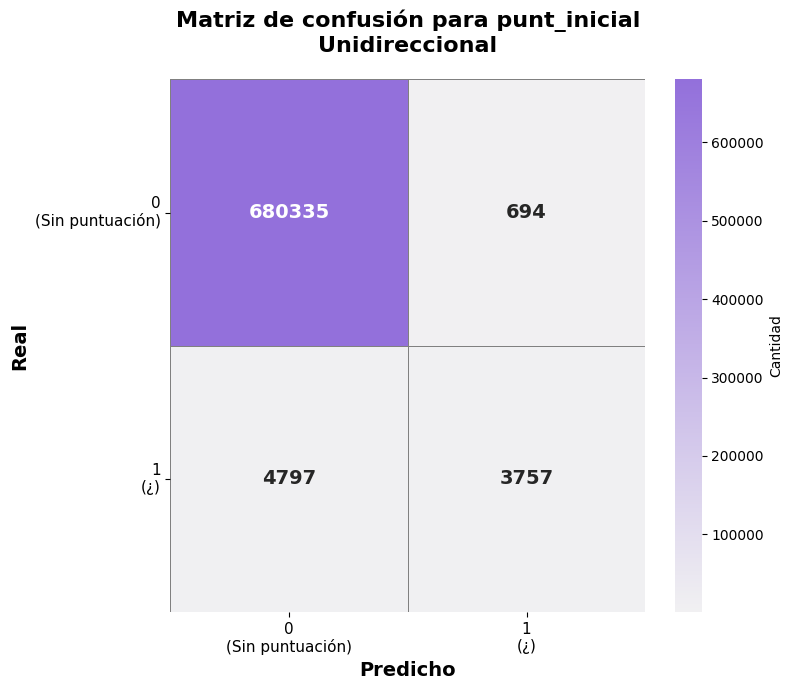

✓ Matriz guardada en: /content/drive/MyDrive/colab/cm_inicial_unidireccional.png
  Accuracy: 0.9920
  Total predicciones: 689,583



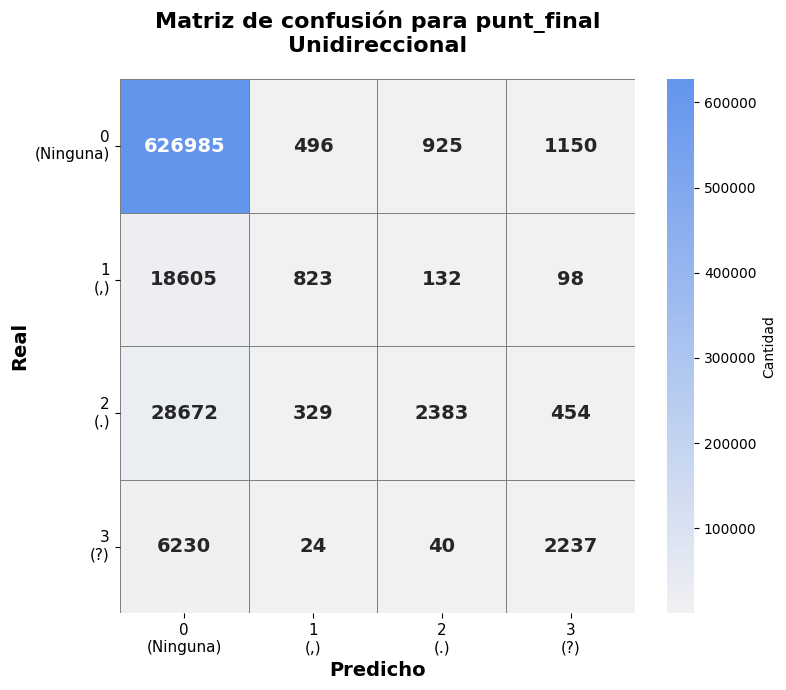

✓ Matriz guardada en: /content/drive/MyDrive/colab/cm_final_unidireccional.png
  Accuracy: 0.9171
  Total predicciones: 689,583



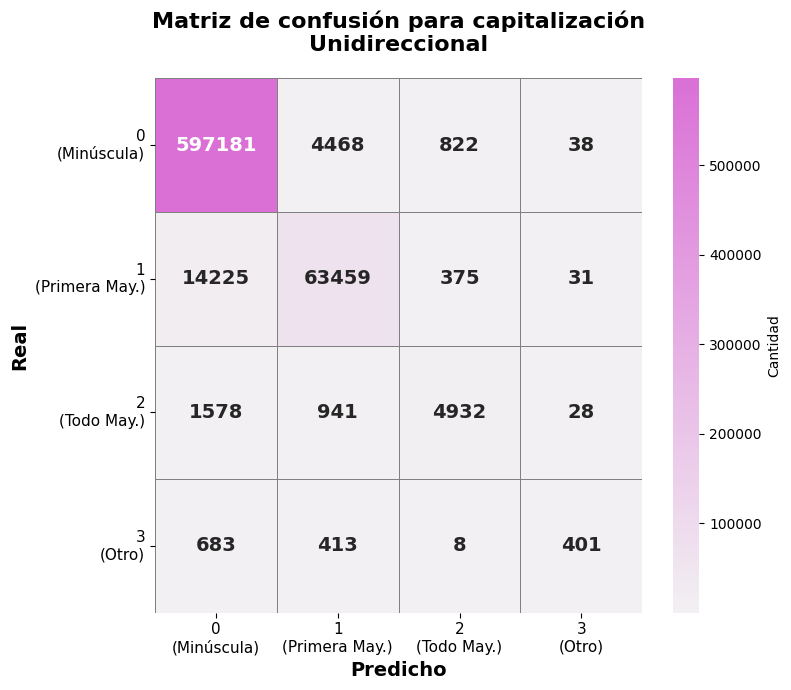

✓ Matriz guardada en: /content/drive/MyDrive/colab/cm_capitalizacion_unidireccional.png
  Accuracy: 0.9658
  Total predicciones: 689,583


  GENERANDO MATRICES - MODELO BIDIRECCIONAL

  MATRICES DE CONFUSIÓN - BIDIRECCIONAL



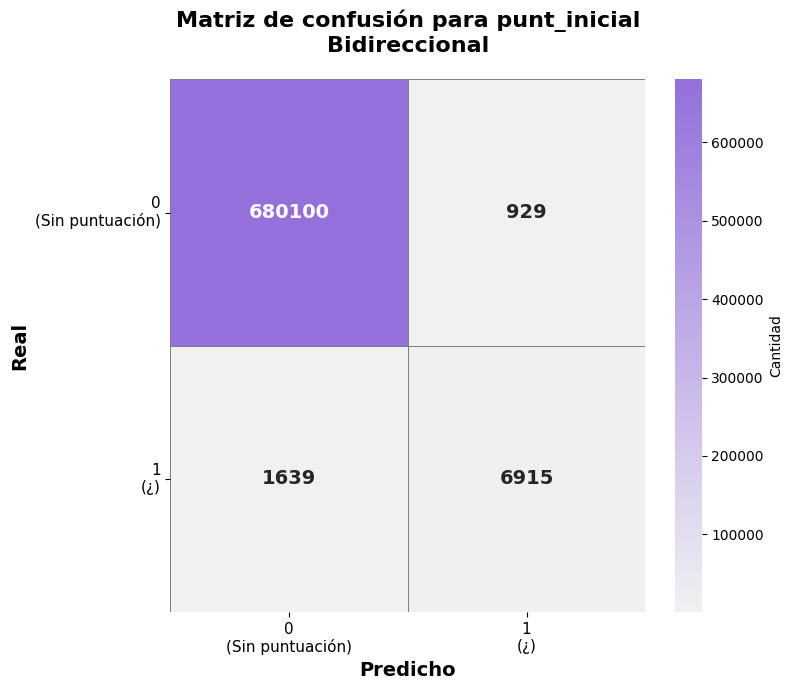

✓ Matriz guardada en: /content/drive/MyDrive/colab/cm_inicial_bidireccional.png
  Accuracy: 0.9963
  Total predicciones: 689,583



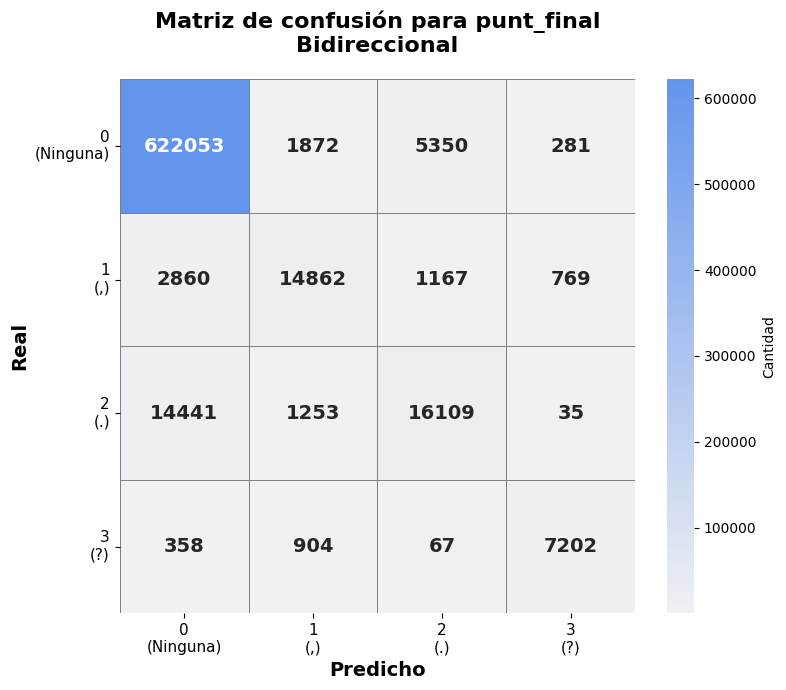

✓ Matriz guardada en: /content/drive/MyDrive/colab/cm_final_bidireccional.png
  Accuracy: 0.9574
  Total predicciones: 689,583



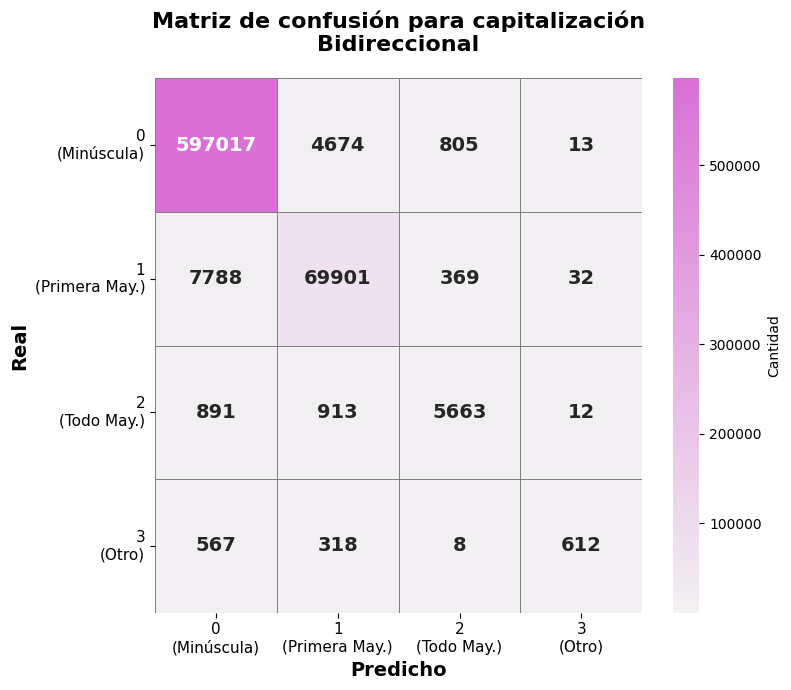

✓ Matriz guardada en: /content/drive/MyDrive/colab/cm_capitalizacion_bidireccional.png
  Accuracy: 0.9762
  Total predicciones: 689,583



In [39]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np
import torch

# ==========================================
# FUNCIÓN PARA MATRICES DE CONFUSIÓN CON SEABORN
# ==========================================

def plot_confusion_matrix_styled(y_true, y_pred, labels, title, filename, cmap='Blues'):
    """
    Genera una matriz de confusión con estilo mejorado usando seaborn

    Args:
        y_true: etiquetas verdaderas
        y_pred: etiquetas predichas
        labels: nombres de las clases
        title: título del gráfico
        filename: ruta donde guardar la imagen
        cmap: mapa de colores (puede ser nombre o lista de colores)
    """
    # Calcular matriz de confusión
    cm = confusion_matrix(y_true, y_pred)

    # Crear figura
    plt.figure(figsize=(8, 7))

    # Usar seaborn para mejor visualización
    sns.heatmap(cm, annot=True, fmt='d', cmap=cmap,
                cbar_kws={'label': 'Cantidad'},
                linewidths=0.5, linecolor='gray',
                xticklabels=labels, yticklabels=labels,
                annot_kws={'size': 14, 'weight': 'bold'})

    plt.title(title, fontsize=16, fontweight='bold', pad=20)
    plt.ylabel('Real', fontsize=14, fontweight='bold')
    plt.xlabel('Predicho', fontsize=14, fontweight='bold')

    # Ajustar etiquetas
    plt.xticks(fontsize=11, rotation=0)
    plt.yticks(fontsize=11, rotation=0)

    plt.tight_layout()
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()

    print(f"✓ Matriz guardada en: {filename}")

    # Calcular y mostrar métricas
    accuracy = np.trace(cm) / np.sum(cm)
    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  Total predicciones: {np.sum(cm):,}")
    print()

    return cm


# ==========================================
# GENERAR MATRICES PARA AMBOS MODELOS
# ==========================================

def generate_all_confusion_matrices(model, test_loader, device, model_name="Unidireccional"):
    """
    Genera las 3 matrices de confusión para un modelo.
    """
    model.eval()

    # Recolectar predicciones
    all_true_init = []
    all_pred_init = []
    all_true_final = []
    all_pred_final = []
    all_true_cap = []
    all_pred_cap = []

    with torch.no_grad():
        for embeddings, labels in test_loader:
            embeddings = embeddings.to(device)
            labels = {k: v.to(device) for k, v in labels.items()}

            outputs = model(embeddings)

            pred_init = outputs["puntuación inicial"].argmax(dim=-1)
            pred_final = outputs["puntuación final"].argmax(dim=-1)
            pred_cap = outputs["capitalización"].argmax(dim=-1)

            mask = (labels["punt_inicial"] != -100)

            all_true_init.extend(labels["punt_inicial"][mask].cpu().tolist())
            all_pred_init.extend(pred_init[mask].cpu().tolist())

            all_true_final.extend(labels["punt_final"][mask].cpu().tolist())
            all_pred_final.extend(pred_final[mask].cpu().tolist())

            all_true_cap.extend(labels["capitalizacion"][mask].cpu().tolist())
            all_pred_cap.extend(pred_cap[mask].cpu().tolist())

    print(f"\n{'='*60}")
    print(f"  MATRICES DE CONFUSIÓN - {model_name.upper()}")
    print(f"{'='*60}\n")

    # Crear mapas de color personalizados
    # Color 1: #9370DB (Púrpura medio)
    cmap1 = sns.light_palette("#9370DB", as_cmap=True)

    # Color 2: #6495ED (Azul aciano)
    cmap2 = sns.light_palette("#6495ED", as_cmap=True)

    # Color 3: #DA70D6 (Orquídea)
    cmap3 = sns.light_palette("#DA70D6", as_cmap=True)

    # ==========================================
    # 1. PUNTUACIÓN INICIAL - Color #9370DB
    # ==========================================
    cm_init = plot_confusion_matrix_styled(
        all_true_init, all_pred_init,
        labels=['0\n(Sin puntuación)', '1\n(¿)'],
        title=f'Matriz de confusión para punt_inicial\n{model_name}',
        filename=f'/content/drive/MyDrive/colab/cm_inicial_{model_name.lower()}.png',
        cmap=cmap1
    )

    # ==========================================
    # 2. PUNTUACIÓN FINAL - Color #6495ED
    # ==========================================
    cm_final = plot_confusion_matrix_styled(
        all_true_final, all_pred_final,
        labels=['0\n(Ninguna)', '1\n(,)', '2\n(.)', '3\n(?)'],
        title=f'Matriz de confusión para punt_final\n{model_name}',
        filename=f'/content/drive/MyDrive/colab/cm_final_{model_name.lower()}.png',
        cmap=cmap2
    )

    # ==========================================
    # 3. CAPITALIZACIÓN - Color #DA70D6
    # ==========================================
    cm_cap = plot_confusion_matrix_styled(
        all_true_cap, all_pred_cap,
        labels=['0\n(Minúscula)', '1\n(Primera May.)', '2\n(Todo May.)', '3\n(Otro)'],
        title=f'Matriz de confusión para capitalización\n{model_name}',
        filename=f'/content/drive/MyDrive/colab/cm_capitalizacion_{model_name.lower()}.png',
        cmap=cmap3
    )

    return cm_init, cm_final, cm_cap


# ==========================================
# EJECUTAR PARA MODELO UNIDIRECCIONAL
# ==========================================

print("\n" + "="*60)
print("  GENERANDO MATRICES - MODELO UNIDIRECCIONAL")
print("="*60)

model_uni = RNN_Unidireccional(embedding_dim=768, hidden_dim1=128, hidden_dim2=32, num_layers=2, dropout=0.4)
device = "cuda" if torch.cuda.is_available() else "cpu"
model_uni = model_uni.to(device)

checkpoint_uni = torch.load("/content/drive/MyDrive/colab/modelosU/mejor_modelo.pt")
model_uni.load_state_dict(checkpoint_uni['model_state_dict'])
model_uni.eval()

cm_init_u, cm_final_u, cm_cap_u = generate_all_confusion_matrices(
    model_uni, test_loader, device, model_name="Unidireccional"
)


# ==========================================
# EJECUTAR PARA MODELO BIDIRECCIONAL
# ==========================================

print("\n" + "="*60)
print("  GENERANDO MATRICES - MODELO BIDIRECCIONAL")
print("="*60)

model_bi = RNN_Bidireccional(embedding_dim=768, hidden_dim1=128, hidden_dim2=32,  num_layers=2, dropout=0.4)
model_bi = model_bi.to(device)

checkpoint_bi = torch.load("/content/drive/MyDrive/colab/modelosB/mejor_modelo.pt")
model_bi.load_state_dict(checkpoint_bi['model_state_dict'])
model_bi.eval()

cm_init_b, cm_final_b, cm_cap_b = generate_all_confusion_matrices(
    model_bi, test_loader, device, model_name="Bidireccional"
)